Lesson 1 introduces to cats vs dogs kaggle problem. I have trained my own classifier to classify man and woman using similar techniques.

In [2]:
# Automatic Reading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# Importing all libraries
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = "data/manwoman/"
sz = 224 # The size of the image to which they have to be reshaped

In [5]:
# Checking if Nvidia GPU is set up
torch.cuda.is_available()

True

In [6]:
# Checking if accelerated functions are working
torch.backends.cudnn.enabled

True

## Looking at examples

In [7]:
os.listdir(PATH)

['.ipynb_checkpoints', 'valid', 'models', 'train', 'tmp']

In [8]:
os.listdir(f'{PATH}valid')

['.ipynb_checkpoints', 'woman', 'man']

In [9]:
files = os.listdir(f'{PATH}valid/man')[:5]
files

['96. godfirnon2.jpg',
 '94. ar-180319990.jpg',
 '91. 636284784691403302-omar-cameron.jpg',
 '98. 5ab4086c5f7f5.image.jpg',
 '92. 636561197329849968-ginter.jpg']

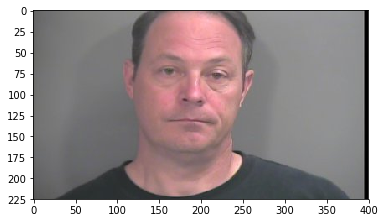

In [10]:
img = plt.imread(f'{PATH}valid/man/{files[0]}')
plt.imshow(img)

In [11]:
# raw data
img.shape

(225, 400, 3)

In [12]:
img[:4, :4]

array([[[ 97,  97,  97],
        [ 99,  99,  99],
        [101, 101, 101],
        [103, 103, 103]],

       [[ 97,  97,  97],
        [ 99,  99,  99],
        [101, 101, 101],
        [103, 103, 103]],

       [[ 97,  97,  97],
        [ 99,  99,  99],
        [101, 101, 101],
        [103, 103, 103]],

       [[ 97,  97,  97],
        [ 99,  99,  99],
        [101, 101, 101],
        [103, 103, 103]]], dtype=uint8)

## Building The First Model

In [13]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 5)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                
    0      0.738495   0.401733   0.85      
    1      0.642754   0.292811   0.9             
    2      0.527353   0.223791   0.9             
    3      0.442442   0.183894   0.95            
    4      0.374748   0.15715    0.95            



[array([ 0.15715]), 0.94999998807907104]

## Analyzing the results

In [14]:
data.val_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [15]:
data.classes

['man', 'woman']

In [16]:
#Getting the prediction for validation set
log_preds = learn.predict()
log_preds

array([[-0.01696, -4.08519],
       [-0.10797, -2.27937],
       [-0.00038, -7.87788],
       [-0.00648, -5.04266],
       [-0.00185, -6.29616],
       [-0.0232 , -3.77527],
       [-0.38007, -1.15141],
       [-0.04605, -3.10103],
       [-0.88341, -0.53336],
       [-0.10322, -2.32203],
       [-1.0267 , -0.44346],
       [-4.42881, -0.012  ],
       [-2.02267, -0.14191],
       [-4.41286, -0.01219],
       [-0.92445, -0.50542],
       [-2.90689, -0.0562 ],
       [-1.42656, -0.27461],
       [-2.14995, -0.12385],
       [-5.74411, -0.00321],
       [-7.4806 , -0.00056]], dtype=float32)

In [17]:
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:, 1]) # pr(woman)
print(probs)

[ 0.01682  0.10235  0.00038  0.00646  0.00184  0.02293  0.31619  0.045    0.58663  0.09807  0.64181  0.98807
  0.8677   0.98788  0.60325  0.94535  0.75987  0.88351  0.9968   0.99944]


In [33]:
def rand_by_mask(mask, num): return np.random.choice(np.where(mask)[0], num, replace=False)
def rand_by_correct(is_correct, num): return rand_by_mask((preds == data.val_y)==is_correct, num)

In [34]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [35]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [36]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


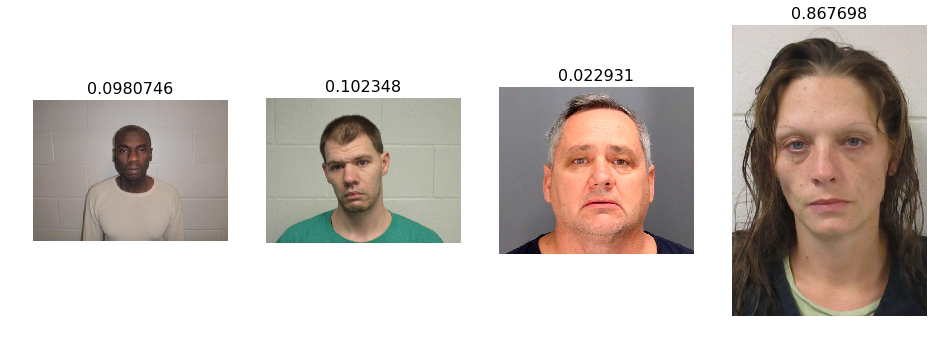

In [37]:
# plotting correct values in random
plot_val_with_title(rand_by_correct(True, 4), "Correctly classified")

Incorrectly classified


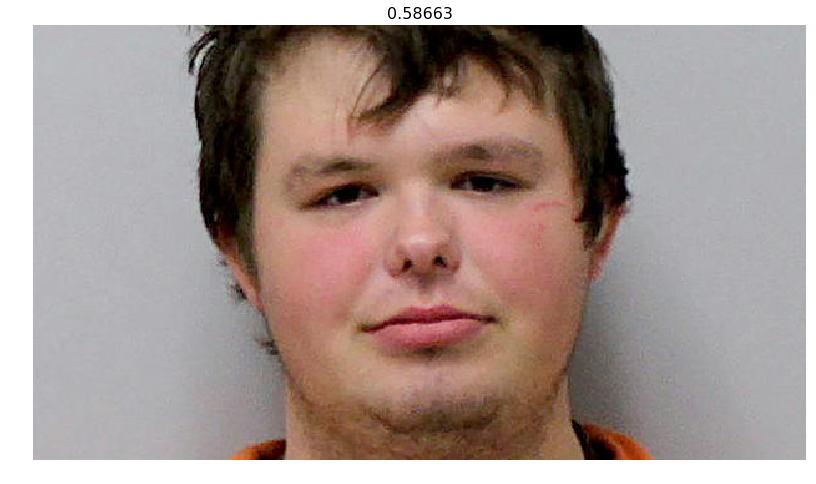

In [38]:
# Incorrectly labelled, there is only 1 incorrectly classified image
plot_val_with_title(rand_by_correct(False, 1), "Incorrectly classified")

In [39]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct man


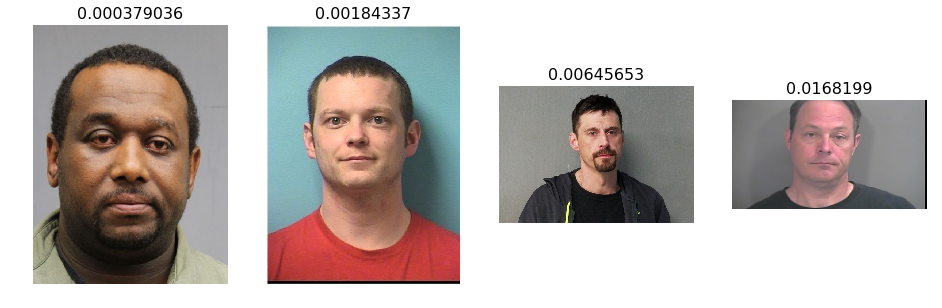

In [40]:
plot_val_with_title(most_by_correct(0, True), "Most correct man")

Most correct woman


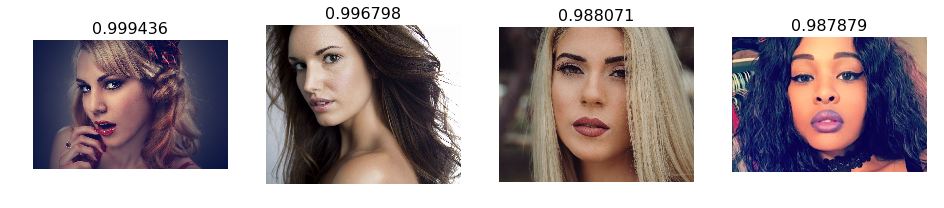

In [42]:
plot_val_with_title(most_by_correct(1, True), "Most correct woman")

## Improving The Model

### Data Augmentation
One of the ways to train a better model is by data augmentation.

In [50]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [53]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x, _ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [54]:
ims = np.stack([get_augs() for i in range(6)])

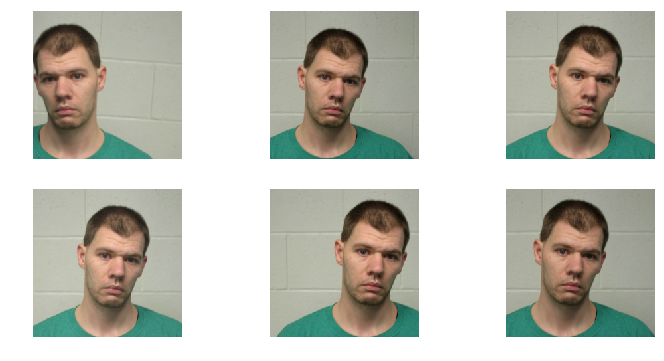

In [55]:
plots(ims, rows=2)

In [77]:
#Creating a new data object that includes augmented data
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [78]:
learn.fit(1e-2, 10)

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss   accuracy        
    0      0.707901   0.571329   0.8       
    1      0.585127   0.378065   0.85            
    2      0.472098   0.282641   0.8             
    3      0.385836   0.234774   0.85            
    4      0.333495   0.205425   0.95            
    5      0.302308   0.173912   0.95            
    6      0.271573   0.147585   0.95            
    7      0.241437   0.13451    0.95            
    8      0.220254   0.12549    1.0             
    9      0.204511   0.115064   0.95            



[array([ 0.11506]), 0.94999998807907104]

### Test Time Augmentation

Augment the data into 4 versions and take the average prediction.

In [86]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)

In [87]:
accuracy_np(probs, y)

0.94999999999999996

## Analyzing Results

### Confusion Matrix
A common way to analyze the result is to use confusion matrix

In [89]:
from sklearn.metrics import confusion_matrix

In [94]:
preds = np.argmax(probs, axis=1)
probs = probs[:, 1]
print(probs)

[ 0.00292  0.003    0.00001  0.0002   0.0005   0.0041   0.52485  0.00041  0.36403  0.00089  0.59891  0.99995
  0.86583  0.99986  0.70404  0.99876  0.9355   0.98342  0.99996  0.99998]


In [97]:
cm = confusion_matrix(y, preds)
#print(y)
#print(preds)

[[ 9  1]
 [ 0 10]]


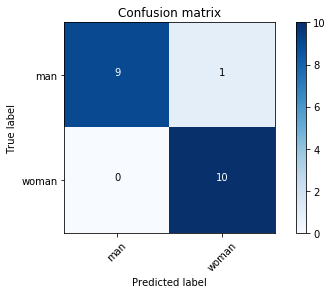

In [98]:
plot_confusion_matrix(cm, data.classes)

## Review: Easy steps to train a world-class image classifier

1. Enable data augmentation
2. Find highest learning rate where loss is still clearly improving
3. Train last layer from precomputed activations for 1-2 epochs
4. Train last layer with data augmentation
5. Unfreeqe all layers
6. Set earlier layers to 3x-10x lower learning rate than next higher layer
7. Find learning rate again
8. Train full network